# Time Series Components

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = [10, 6]

## Extract Data
We will use the Alpha Vantage API to extract the historical daily closing stock prices of AT&T and Verizon for the period of 01/01/2019 to 06/01/2021. AT&T's symbol is `T`, and Verizon's is `VZ`.

In [2]:
t_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&outputsize=full&symbol=T&apikey=TO341WKQ7RCQEI15&datatype=csv'
v_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&outputsize=full&symbol=VZ&apikey=TO341WKQ7RCQEI15&datatype=csv'
t_df = pd.read_csv(t_url, parse_dates=['timestamp'], index_col='timestamp').sort_index().convert_dtypes()
v_df = pd.read_csv(v_url, parse_dates=['timestamp'], index_col='timestamp').sort_index().convert_dtypes()

In [3]:
start_date = '2019-01-01'
end_date = '2021-06-01'
t_df = t_df[start_date:end_date]
t_df.head()

,open,high,low,close,volume
timestamp,,,,,
2019-01-02,28.5,29.59,28.3,29.54,39293953
2019-01-03,29.52,29.81,29.21,29.58,37603571
2019-01-04,29.96,30.38,29.89,30.34,42072388
2019-01-07,30.73,31.27,30.42,30.89,41070898
2019-01-08,31.31,31.38,31.03,31.28,43567261


In [4]:
v_df = v_df[start_date:end_date]
v_df.head()

,open,high,low,close,volume
timestamp,,,,,
2019-01-02,56.16,56.16,55.28,56.02,13969691
2019-01-03,56.3,56.99,56.06,56.22,19245411
2019-01-04,56.49,56.89,55.95,56.36,17035848
2019-01-07,56.76,57.26,56.55,56.72,16348982
2019-01-08,57.27,58.69,57.05,58.38,21425008


In [5]:
t_df.to_csv("../data/t.csv")
v_df.to_csv("../data/v.csv")

merged_df = pd.merge(t_df.close, v_df.close, how='outer', left_index=True, right_index=True, suffixes=('_t', '_v'))

In [6]:
merged_df.head(20)

,close_t,close_v
timestamp,,
2019-01-02,29.54,56.02
2019-01-03,29.58,56.22
2019-01-04,30.34,56.36
2019-01-07,30.89,56.72
2019-01-08,31.28,58.38
2019-01-09,30.1,57.05
2019-01-10,30.4,57.6
2019-01-11,30.87,58.02
2019-01-14,30.62,58.03


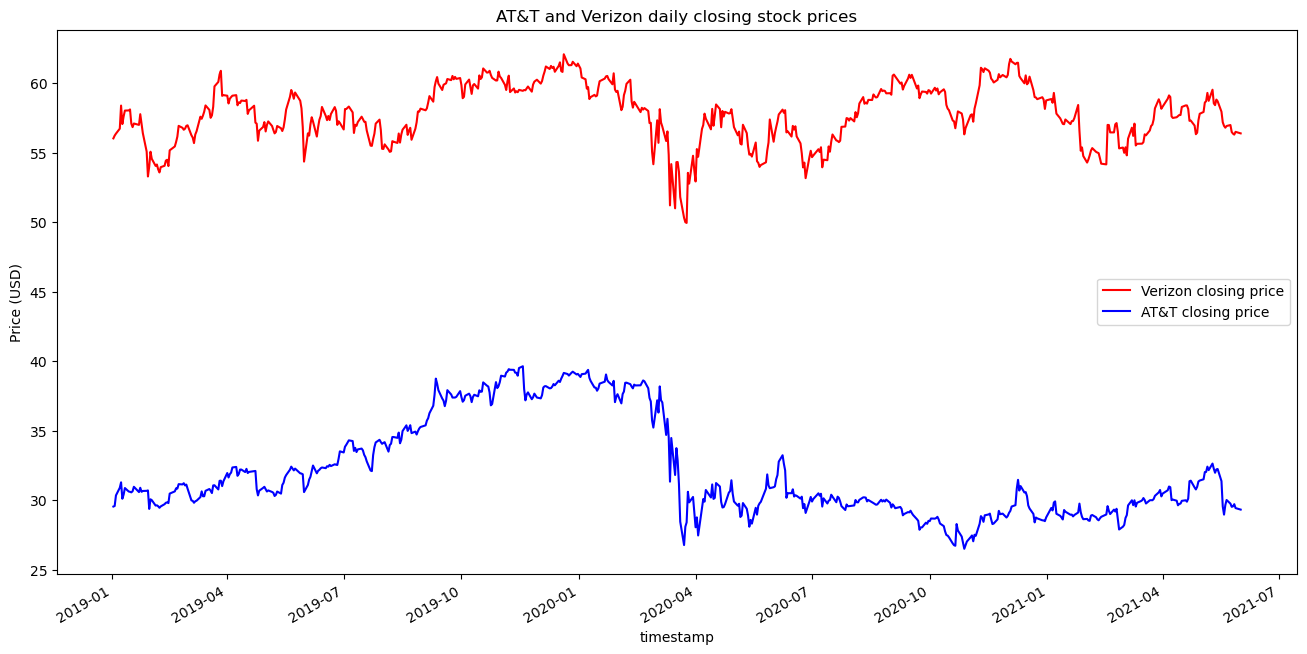

In [26]:
ax1 = merged_df.plot(y='close_v', color='red', label='Verizon closing price', title='AT&T and Verizon daily closing stock prices', ylabel='Price (USD)',figsize=(16,8))
ax2 = merged_df.plot(y="close_t", color="blue", label="AT&T closing price", ax=ax1)
plt.legend(loc="center right")
plt.savefig("../images/att_vz_prices.png", bbox_inches='tight')

In [8]:
# Verify index frequency
print(f'Index frequency is: {merged_df.index.freq}')

Index frequency is: None


In [9]:
# Infer the frequency. Could use `.asfreq('D')` as well.
merged_df = merged_df.asfreq(pd.infer_freq(merged_df.index))

In [10]:
# Verify index frequency was inferred correctly
print(f"Index frequency is: {merged_df.index.freq}")

Index frequency is: <Day>


In [11]:
# This dataset is probably missing values for holidays. Let's do forward-fill to represent the stock's standing price.
merged_df = merged_df.asfreq("D").ffill()

In [12]:
merged_df.head(20)

,close_t,close_v
timestamp,,
2019-01-02,29.54,56.02
2019-01-03,29.58,56.22
2019-01-04,30.34,56.36
2019-01-05,30.34,56.36
2019-01-06,30.34,56.36
2019-01-07,30.89,56.72
2019-01-08,31.28,58.38
2019-01-09,30.1,57.05
2019-01-10,30.4,57.6


In [13]:
# Create seasonal decomposition models for both stocks' closing prices
t_decompose = seasonal_decompose(merged_df.close_t, model="additive")
v_decompose = seasonal_decompose(merged_df.close_v, model="additive")

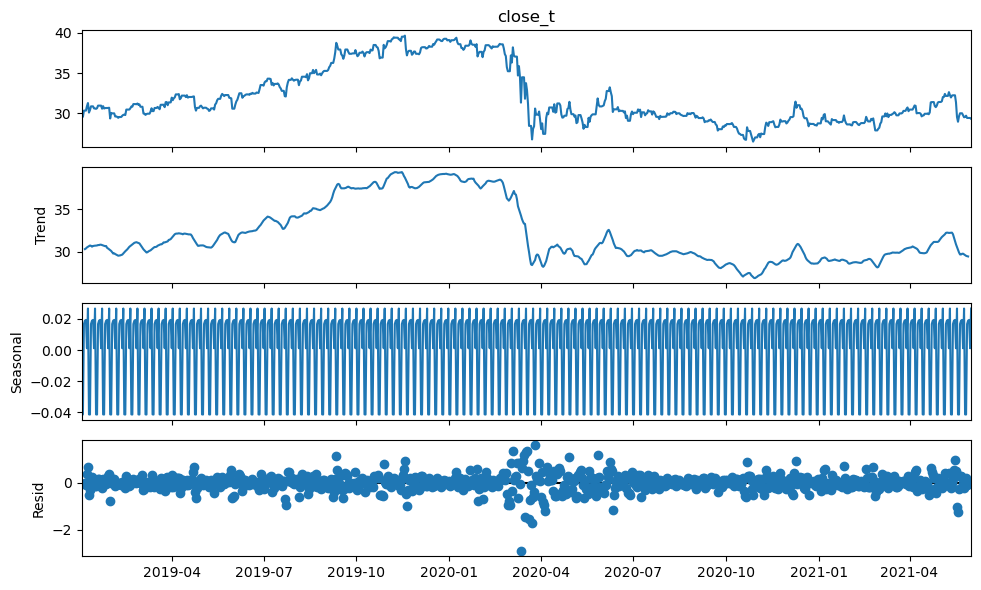

In [15]:
# Plot the decomposed AT&T closing price
t_decompose.plot()
plt.show()

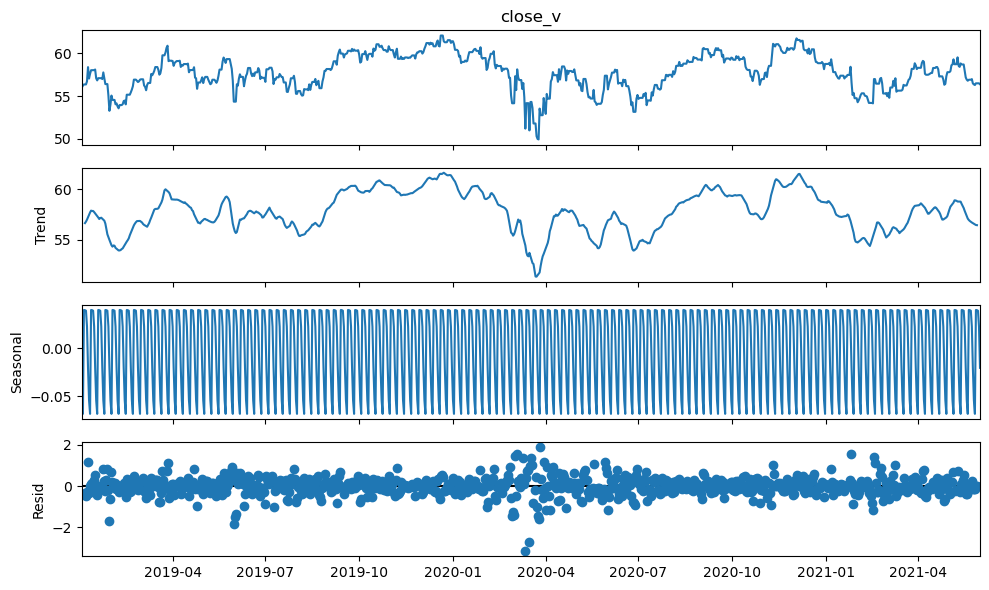

In [16]:
# Plot the decomposed Verizon closing price
v_decompose.plot()
plt.show()

The residuals for both models show that the closing prices of both stocks exhibited anomalous behavior right before April 2020. This is likely due to the COVID-19 pandemic.

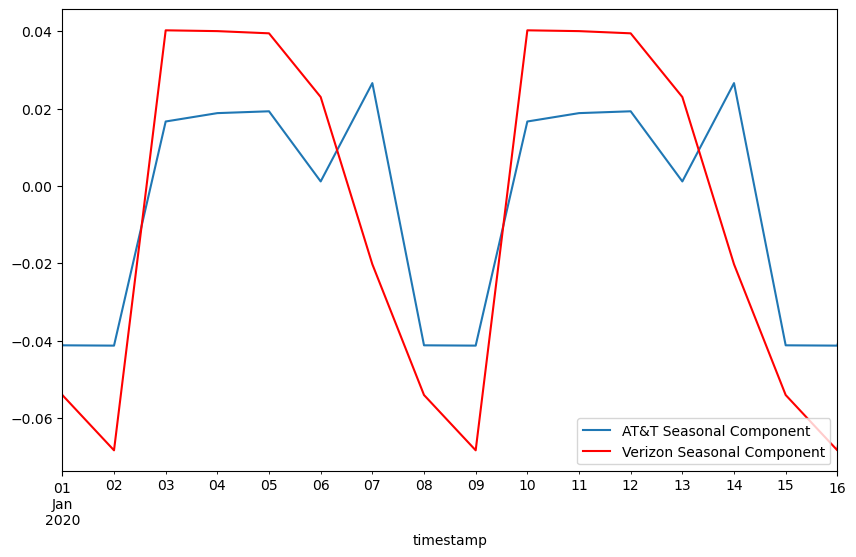

In [17]:
# Plot the seasonal component of both stocks
ax = t_decompose.seasonal.plot(kind='line', label='AT&T Seasonal Component')
ax2 = v_decompose.seasonal.plot(color='red', label='Verizon Seasonal Component', ax=ax)
ax.set_xlim(pd.Timestamp("2020-01-01"), pd.Timestamp("2020-01-16"))
plt.legend()

Both datasets have a seven-day trend, which is fairly common for data-generating processes.

## Identifying Time Series Components

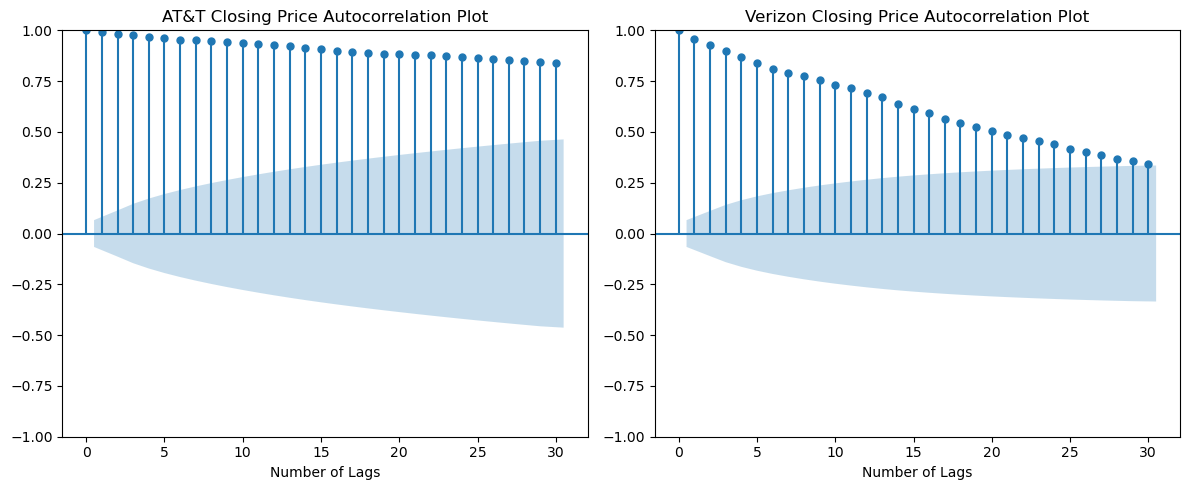

In [18]:
# Plot the autocorrelation of both series' closing prices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns of subplots

# Plot ACF for AT&T Differenced Series
plot_acf(
    merged_df.close_t,
    lags=30,
    title="AT&T Closing Price Autocorrelation Plot",
    ax=ax[0],
)
ax[0].set_xlabel("Number of Lags")

# Plot ACF for Verizon Differenced Series
plot_acf(
    merged_df.close_v,
    lags=30,
    title="Verizon Closing Price Autocorrelation Plot",
    ax=ax[1],
)
ax[1].set_xlabel("Number of Lags")

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

The closing price changes show dependencies between each observation and its previous value. This is characteristic of random walks *or* strongly-trended data: random walks have strong correlation to the previous value, and trends create long-term correlations between the data points. While a random walk may look as though it has a trend, these "trends" are actually stochastic and unpredictable, whereas a long-term trend is predictable and can be modeled. This is not necessarily a problem: we have several tools to deal with this kind of data, such as differencing and statistical tests of stationarity.

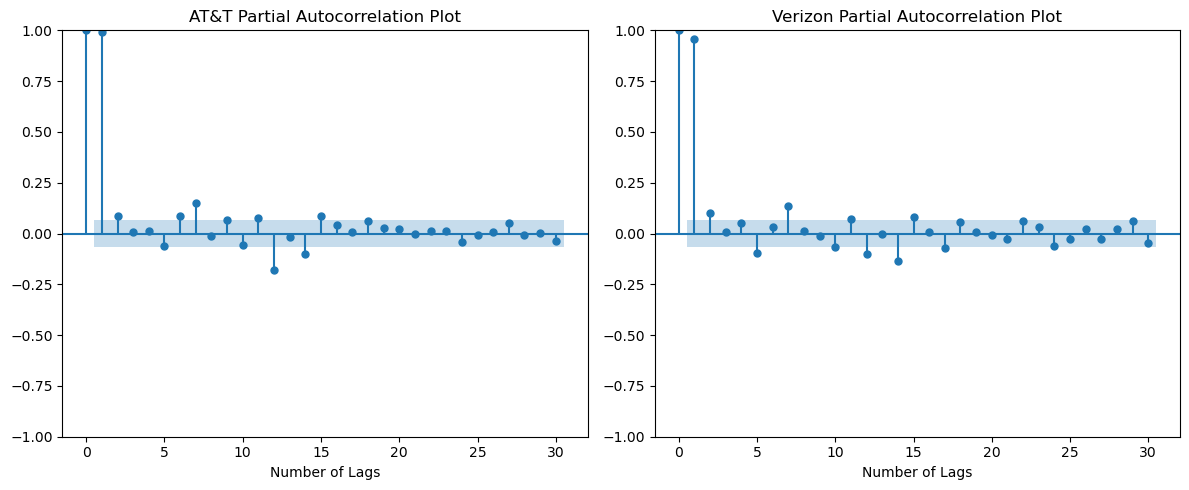

In [19]:
# Plot the partial autocorrelation function of each stocks' closing prices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns of subplots

# Plot PACF for AT&T Differenced Series
plot_pacf(
    merged_df.close_t,
    lags=30,
    title="AT&T Partial Autocorrelation Plot",
    ax=ax[0],
)
ax[0].set_xlabel("Number of Lags")

# Plot PACF for Verizon Series
plot_pacf(
    merged_df.close_v,
    lags=30,
    title="Verizon Partial Autocorrelation Plot",
    ax=ax[1],
)
ax[1].set_xlabel("Number of Lags")

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

The PACF plots point to a simpler data-generating process: short-term dependencies that may be explained by `AR(1)` or `AR(2)` models. They also gesture toward seasonality with peaks at intervals of 7 days. This is consistent with the observed trend in the data. 

## Dealing with Non-Stationarity

In [20]:
# Conduct an Augmented Dickey-Fuller test on both stocks' closing prices
t_adf = adfuller(merged_df.close_t)
v_adf = adfuller(merged_df.close_v)

In [21]:
print(f'AT&T ADF Statistic: {t_adf[0]}')
print(f"AT&T p-value: {t_adf[1]}")
print(f"Verizon ADF Statistic: {v_adf[0]}")
print(f"Verizon p-value: {v_adf[1]}")

AT&T ADF Statistic: -1.5547505368231354
AT&T p-value: 0.5062743893856806
Verizon ADF Statistic: -3.4885579777312197
Verizon p-value: 0.008285858111007767


In [22]:
# Both datasets don't appear to be stationary
# Difference the data and re-run the ADF test
merged_df = merged_df.assign(t_diff=merged_df.close_t.diff(periods=1))
merged_df = merged_df.assign(v_diff=merged_df.close_v.diff(periods=1))
merged_df = merged_df.fillna(0)
merged_df.head()

,close_t,close_v,t_diff,v_diff
timestamp,,,,
2019-01-02,29.54,56.02,0.0,0.0
2019-01-03,29.58,56.22,0.04,0.2
2019-01-04,30.34,56.36,0.76,0.14
2019-01-05,30.34,56.36,0.0,0.0
2019-01-06,30.34,56.36,0.0,0.0


In [23]:
print(f"AT&T ADF Statistic: {adfuller(merged_df.t_diff)[0]}")
print(f"AT&T p-value: {adfuller(merged_df.t_diff)[1]}")
print(f"Verizon ADF Statistic: {adfuller(merged_df.v_diff)[0]}")
print(f"Verizon p-value: {adfuller(merged_df.v_diff)[1]}")

AT&T ADF Statistic: -7.65433561103273
AT&T p-value: 1.7552464348373546e-11
Verizon ADF Statistic: -7.428178984000163
Verizon p-value: 6.465083459794504e-11


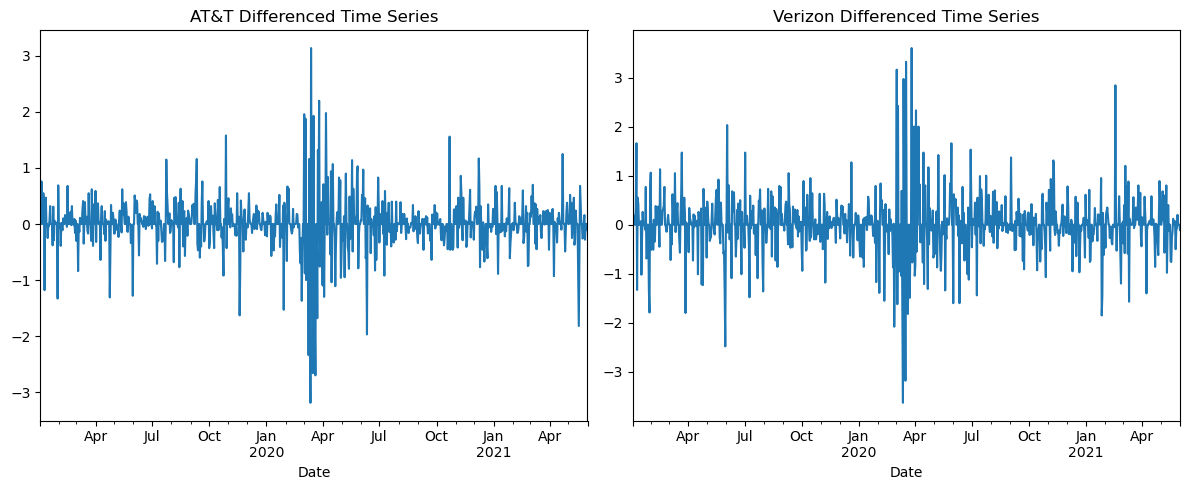

In [24]:
# Plot the differenced time series
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns of subplots

# Plot AT&T Differenced Time Series
merged_df.t_diff.plot(title='AT&T Differenced Time Series', ax=ax[0])
ax[0].set_xlabel("Date")

# Plot Verizon Differenced Time Series
merged_df.v_diff.plot(title='Verizon Differenced Time Series', ax=ax[1])
ax[1].set_xlabel("Date")

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

The differenced time series suggest that the time series are closer to stationarity, as they appear to have a more constant mean and variance. The anomaly in March 2020 is still present in the residuals, but the rest of the data appears to be stationary (or close to it).

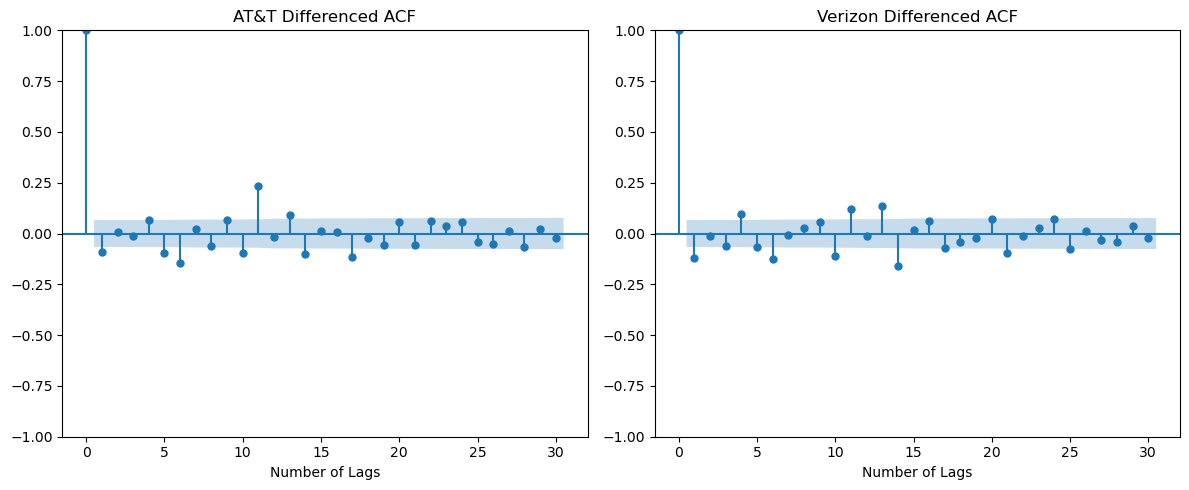

In [25]:
# Plot the autocorrelation of the differenced series
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns of subplots

# Plot ACF for AT&T Differenced Series
plot_acf(merged_df.t_diff, lags=30, title="AT&T Differenced ACF", ax=ax[0])
ax[0].set_xlabel("Number of Lags")

# Plot ACF for Verizon Differenced Series
plot_acf(merged_df.v_diff, lags=30, title="Verizon Differenced ACF", ax=ax[1])
ax[1].set_xlabel("Number of Lags")

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

The augmented Dickey Fuller test, as well as time-series plots and ACF plots, indicate that differencing the time series removed the unit root and made them stationary.

In [26]:
# Save the merged dataframe to a CSV file
merged_df.to_csv("../data/merged_df.csv")